<a href="https://colab.research.google.com/github/hoodasumit/cs666student/blob/main/CS666_Assignment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

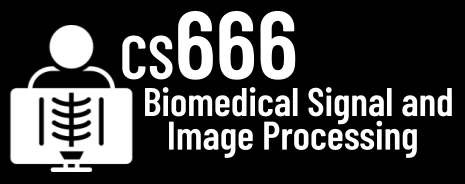
#Assignment 4

In [5]:
# NAME: Sumit Hooda

In [2]:
# In this assignment, we will create a Random Forest classifier to detect pneumonia and covid in xrays!

In [3]:
# load numpy and matplotlib
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
# we are using mahotas again, so lets install it!
!pip install mahotas --no-binary :all:

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 18.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
Skipping wheel build for mahotas, due to binaries being disabled for it.
  Running setup.py install for mahotas ... done


In [6]:
# our imports include sklearn this time
import mahotas as mh
import os
from sklearn.ensemble import RandomForestClassifier

**Task 1:** Download, extract, and load the data! [15 Points]

In [7]:
# Please download this file: https://cs666.org/data/xray/
# This is a subset of the Kaggle Pneumonia + Covid Datasets!
#
# TODO: Upload xray.zip using the file panel on the left.

In [8]:
# Run this code to extract the zip file and to create
# the folder structure of normal/, pneumonia/, and covid/ images.
# Each folder contains the first images of the Kaggle datasets.
import zipfile
with zipfile.ZipFile('xray.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

NORMAL_DIR = 'normal/'
PNEUMONIA_DIR = 'pneumonia/'
COVID_DIR = 'covid/'

In [9]:
# Here we load the first image from the normal dataset.
img = mh.imread(NORMAL_DIR + 'IM-0115-0001.jpeg')

In [ ]:
# TODO: Please display this image and print the dimensions!

In [ ]:
# TODO: YOUR CODE

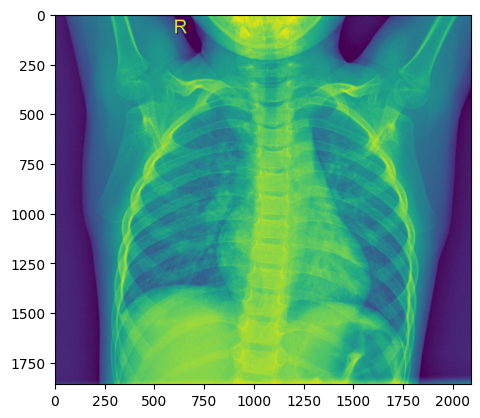

In [10]:
imshow(img)

In [11]:
print("Dimensions: ", img.shape)

Dimensions:  (1858, 2090)


**Task 2:** Let's do some data wrangling and more visualization! [35 Points]

In [12]:
folders = [NORMAL_DIR, PNEUMONIA_DIR, COVID_DIR]
data = [[],[],[]]

for f_index,f in enumerate( folders ):
  all_files = os.listdir( f )

  data[f_index] = np.zeros( (len(all_files), 300, 300), dtype=np.float32)

  for i in range(len(all_files)):
    loaded_image = mh.imread( f + '/' + all_files[i] )
    if loaded_image.ndim > 2:
      loaded_image = mh.colors.rgb2gray(loaded_image[:,:,:3])

    loaded_image = mh.imresize( loaded_image, (300, 300) )
    img_shape = loaded_image.shape

    data[f_index][ i, 0:img_shape[0], 0:img_shape[1] ] = loaded_image

In [14]:
# The two code blocks above perform 3 data wrangling operations.
# Which ones?
# Hint: The first two might be more obvious but the third one happens in the
# last line.
# TODO: Operation 1) YOUR ANSWER
# TODO: Operation 2) YOUR ANSWER
# TODO: Operation 3) YOUR ANSWER

Operation 1:- The first operation involves extracting all files from three different directories, namely Normal_Dir, Pneumonia_Dir, and Covid_Dir.

Operation 2:- The second operation uses iteration to traverse over these extracted files and select only those images which have more than two dimensions. Then, the selected images are converted from RGB to grayscale. In the final step of this operation, the grayscale images are resized to 300 x 300 pixels.

Operation 3:- For the third operation, we initialize a numpy array called data[f_index] with all elements set to 0 and of data type float. Then, we reload the gray resized images using the data[f_index] array.


In [ ]:
# Now, let's look at the first 5 normal_images and the first 5 pneumonia_images.
# TODO: Please visualize multiple images at once.
# Hint: You can use one of the following answers from StackOverflow for this:
# https://stackoverflow.com/questions/41210823/using-plt-imshow-to-display-multiple-images

In [ ]:
# TODO: YOUR CODE

NORMAL IMAGES


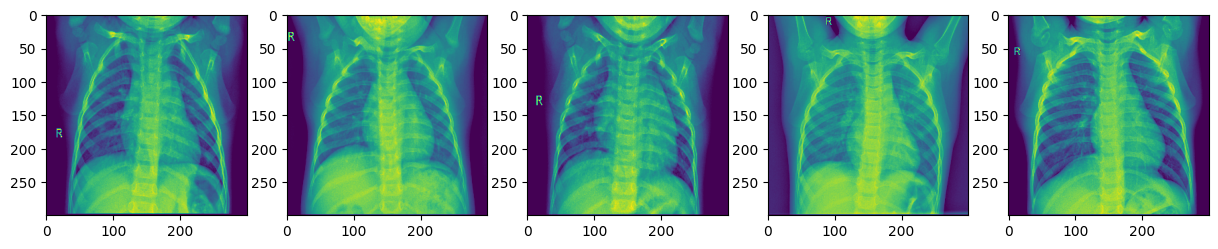

In [13]:
print("NORMAL IMAGES")
import matplotlib.pyplot as plt

v_slice = [data[0][i] for i in range(5)]

f, axarr = plt.subplots(1, 5, figsize=(15, 6))

for i in range(5):
    axarr[i].imshow(v_slice[i])


PNEUMONIA IMAGES


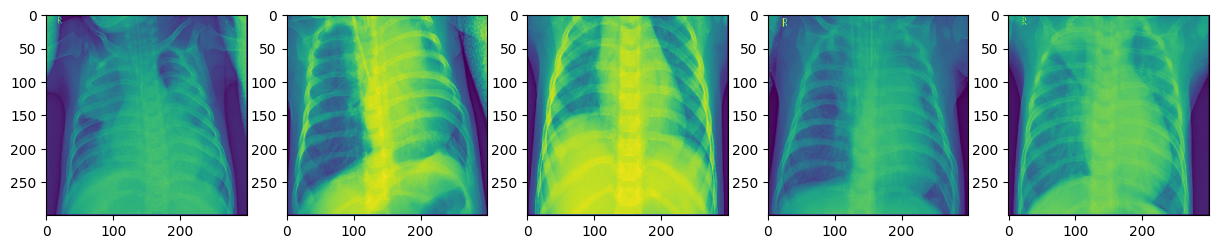

In [14]:
print("PNEUMONIA IMAGES")
import matplotlib.pyplot as plt

v_slice = [data[1][i] for i in range(5)]

f, axarr = plt.subplots(1, 5, figsize=(15, 6))

for i in range(5):
    axarr[i].imshow(v_slice[i])

**Task 3:** Setup training and testing data. [15 Points]

In [ ]:
# Any supervised machine learning algorithm requires disjunct sets of
# training and testing data.
#
# For each, we will create a balanced dataset that includes an equal number
# of normal xrays, pneumonia xrays, and covid xrays.
#
# The training data X_train will include 180 images (60 normal, 60 pneumonia, 60 covid).
# The testing data X_test will include the remaining 120 images (40 normal, 40 pneumonia, 40 covid).
#
# Supervised learning means that we tell the algorithm which image is normal
# and which image is pneumonia. For this, we need the y_train vector.
# The vector shall be 0 for a normal image, and 1 for a pneumonia, and 2 for a covid scan.

In [71]:
TRAINING_COUNT = 60

X_train = np.zeros( (TRAINING_COUNT * 3, 300*300 ), dtype=np.float32)
t_pos = 0

for d in data:
  for image in d[0:TRAINING_COUNT]:
    image = image.ravel() # flatten the image
    image /= image.max() # normalize the image
    X_train[t_pos] = image
    t_pos += 1

In [72]:
# TODO: Please create the y_train vector with 0 for a normal image, 
# 1 for a pneumonia, and 2 for covid. This needs to a numpy array.
y_train = np.zeros((TRAINING_COUNT * 3), dtype=np.int32)
y_train[TRAINING_COUNT:2*TRAINING_COUNT] = 1
y_train[2*TRAINING_COUNT:] = 2
print(y_train)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


In [73]:
TESTING_COUNT = 40

X_test = np.zeros( (TESTING_COUNT * 3, 300*300 ), dtype=np.float32)
t_pos = 0

for d in data:
  for image in d[0:TESTING_COUNT]:
    image = image.ravel() # flatten the image
    image /= image.max() # normalize the image
    X_test[t_pos] = image
    t_pos += 1

In [74]:
# TODO: Please create the y_test vector with 0 for a normal image, 
# 1 for a pneumonia, and 2 for covid. This needs to a numpy array.

y_test = np.zeros((TESTING_COUNT * 3,), dtype=np.int32)
y_test[0:TESTING_COUNT] = 0
y_test[TESTING_COUNT:TESTING_COUNT*2] = 1
y_test[TESTING_COUNT*2:] = 2
print(y_test)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2]


**Task 4:** Let's train and evaluate the Random Forest! [35 Points]

In [75]:
# Let's shuffle our training data.
p = np.random.permutation(len(X_train))
X_train = X_train[p]
y_train = y_train[p]

In [76]:
# With scikit-learn, we can easily set up a default Random Forest classifier.
clf = RandomForestClassifier()

In [77]:
# Now, we train the classifier with the training data and the training targets.
# We essentially show the classifier an image and tell whether the image is 
# normal or pneumonia or covid.
fitted = clf.fit( X_train, y_train )

In [64]:
# TODO: In just a few sentences, please explain how the Random Forest works.

In [65]:
# TODO: YOUR ANSWER

A random forest model is built by creating multiple decision trees on different samples of data. Each tree in the random forest produces a class prediction, and the class that receives the most votes across all trees becomes the final prediction of the model.

In [78]:
# After training, we can see how well the classifier predicts our testing data.
# The following command will return the classification accuracy.
clf.score( X_test, y_test )

1.0

In [ ]:
# TODO: Is the classification accuracy good? And, are you surprised?

In [ ]:
# TODO: YOUR ANSWER

Yes, It is really good and I am surprized.

**Bonus:** Let's take a closer look! [33 Points]

In [ ]:
# Let's run the fitted classifier on the remaining covid images.
# You might have noticed that there are 199 covid images but we only used 100 so far.
# Please evaluate the classifier on the remaining (previously unseen) 99 covid images
# and check the performance.

In [82]:
# TODO: YOUR CODE AND YOUR ANSWER



cvd_imgs = data[2]
cvd_imgs_left = cvd_imgs[100:]


X_train_r = np.zeros((99, 300*300), dtype=np.float32)
t_pos = 0
for d in cvd_imgs_left:
    image = image.ravel()
    image /= image.max()
    X_train_r[t_pos] = image
    t_pos += 1

y_train_r = np.full((99,), 2, dtype=np.float32)


X_test_r = np.zeros((40, 300*300), dtype=np.float32)
test_pos = 0
for d in covid_remaining_images[0:40]:
    image = image.ravel()
    image /= image.max()
    X_test_r[test_pos] = image
    test_pos += 1

y_test_r = np.full((40,), 2, dtype=np.float32)

p = np.random.permutation(len(X_train_r))
X_train_r = X_train_r[p]
y_train_r = y_train_r[p]

fitted = clf.fit(X_train_r, y_train_r)
clf.score(X_test_r, y_test_r)
     


1.0

In [ ]:
# Great job!!!
#           ___
#       _.-'   \
#      /        \
#     /          \
#    /            `.___
#   ( .--.)\/(,.--.    `-.
#   ,',-. \   / ,-.`.     )
#  ( /   \     /   \ )   / \
#   || .-|     |-. ||---'|  \
#  _|| | |     | | ||_   |   \
# /. \ |_|.---.|_| / ,\  | .^.\
# `.\ `--"     "--' /,'  |/
#   `>  _________ <'
# ,-' ,---.---.---. `-.
# `--'\    \j/    /`--'
#    `.\         /,'
#      \\_______//
#       `-------'       hjw